In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

## The Data Structure

The data I use for current visulization is **transaction records** generated from a generated movement probability matrix(which is also the data source of the movement heatmap).

Currently, it is a 16800 * 8 table with 2100 identities.

In [2]:
%%time
#read data and change data type
record_with_tinterval = pd.read_csv("data_example_short_with_type.csv", index_col = 0)

record_with_tinterval["time"] =  pd.to_datetime(record_with_tinterval["time"])
record_with_tinterval["time_interval_to_next"] =  pd.to_timedelta(record_with_tinterval["time_interval_to_next"])
record_with_tinterval["time_interval_from_last"] =  pd.to_timedelta(record_with_tinterval["time_interval_from_last"])
record_with_tinterval.head()

CPU times: user 105 ms, sys: 3.64 ms, total: 108 ms
Wall time: 109 ms


,name,mcc,merchant,time,transaction_value,transaction_type,time_interval_to_next,time_interval_from_last
0,people0,"Grocery Stores, Supermarkets",merchantB,2020-04-30 09:00:00,74,offline,01:12:00,00:00:00
1,people0,"Motor Freight Carriers, Moving and Storage Com...",merchantA,2020-04-30 10:12:00,15,online,01:28:00,01:12:00
2,people0,"Motor Freight Carriers, Moving and Storage Com...",merchantB,2020-04-30 11:40:00,68,offline,00:56:00,01:28:00
3,people0,Drug Stores and Pharmacies,merchantC,2020-04-30 12:36:00,40,online,00:18:00,00:56:00
4,people0,Drug Stores and Pharmacies,merchantC,2020-04-30 12:54:00,36,online,01:25:00,00:18:00


In [3]:
record_with_tinterval.shape

(16800, 8)

In [4]:
len(record_with_tinterval["name"].unique())

2100

In the data, each row represents one transaction.

The columns are:
* *name*: the identity identifier.
* *mcc*: the Merchant Category Code.
* *merchant*: name of merchant.
* *time* the time point of the transaction.
* *transaction_value*: the amount of the transaction.
* *transaction_type*: the type of the transaction, offline/online.
* *time_interval_to_next*: For a specific person, the time interval between this transaction and next transaction. Calculated from *time* column. 
* *time_interval_to_next*: For a specific person, the time interval between last transaction and next transaction. Calculated from *time* column. 

Other information like geographic location can also be included into the records.

## Background Techniques

First, a time filter is applied to the data.

In [5]:
#apply time filter: start time -> end time
startTime = pd.Timestamp("2020-04-30 10:00:00")
endTime = pd.Timestamp("2020-04-30 18:00:00")
test_time_range_filtered = record_with_tinterval[(record_with_tinterval["time"] > startTime)
                      & (record_with_tinterval["time"] < endTime)]


Then, follwing each person's trajectory, the sequence numbers (1,2,3,4...) of trajectory points (MCCs) are assigned

In [6]:
#give each step a rank number
test_time_range_filtered["step"] = test_time_range_filtered.groupby(["name"])["time"].rank().astype(int)

In [7]:
test_time_range_filtered.head()

,name,mcc,time,transaction_value,time_interval_to_next,time_interval_from_last,step
1,people0,"Furniture, Home Furnishings, and Equipment Sto...",2020-04-30 11:20:00,71,00:02:00,02:20:00,1
2,people0,Fast Food Restaurants,2020-04-30 11:22:00,79,00:32:00,00:02:00,2
3,people0,Book Stores,2020-04-30 11:54:00,28,02:14:00,00:32:00,3
4,people0,"Motor Freight Carriers, Moving and Storage Com...",2020-04-30 14:08:00,48,00:09:00,02:14:00,4
5,people0,Drug Stores and Pharmacies,2020-04-30 14:17:00,35,02:31:00,00:09:00,5


Next, a query is conducted. Take a single MCC, *Bakeries*, as an example.

Before aggregating all the individual trajectories, an important step is **alignment**, which means aligning all the queried trajectory points in every trajectories (MCC).<br>
The steps would be:
1. Take all the trajectories that pass the station "Bakeries"
2. In each trajectory, find the sequence number (step) of "Bakeries". If a person pass "Bakeries" multiple times, keep the min sequence number.
3. Find the max number in all the sequence numbers; then calculate the difference between that max sequence of "Bakeries" and the sequence of "Bakeries" in each single trajectory.
4. For each trajectory, change the sequence numbers to align all the first "Bakeries".

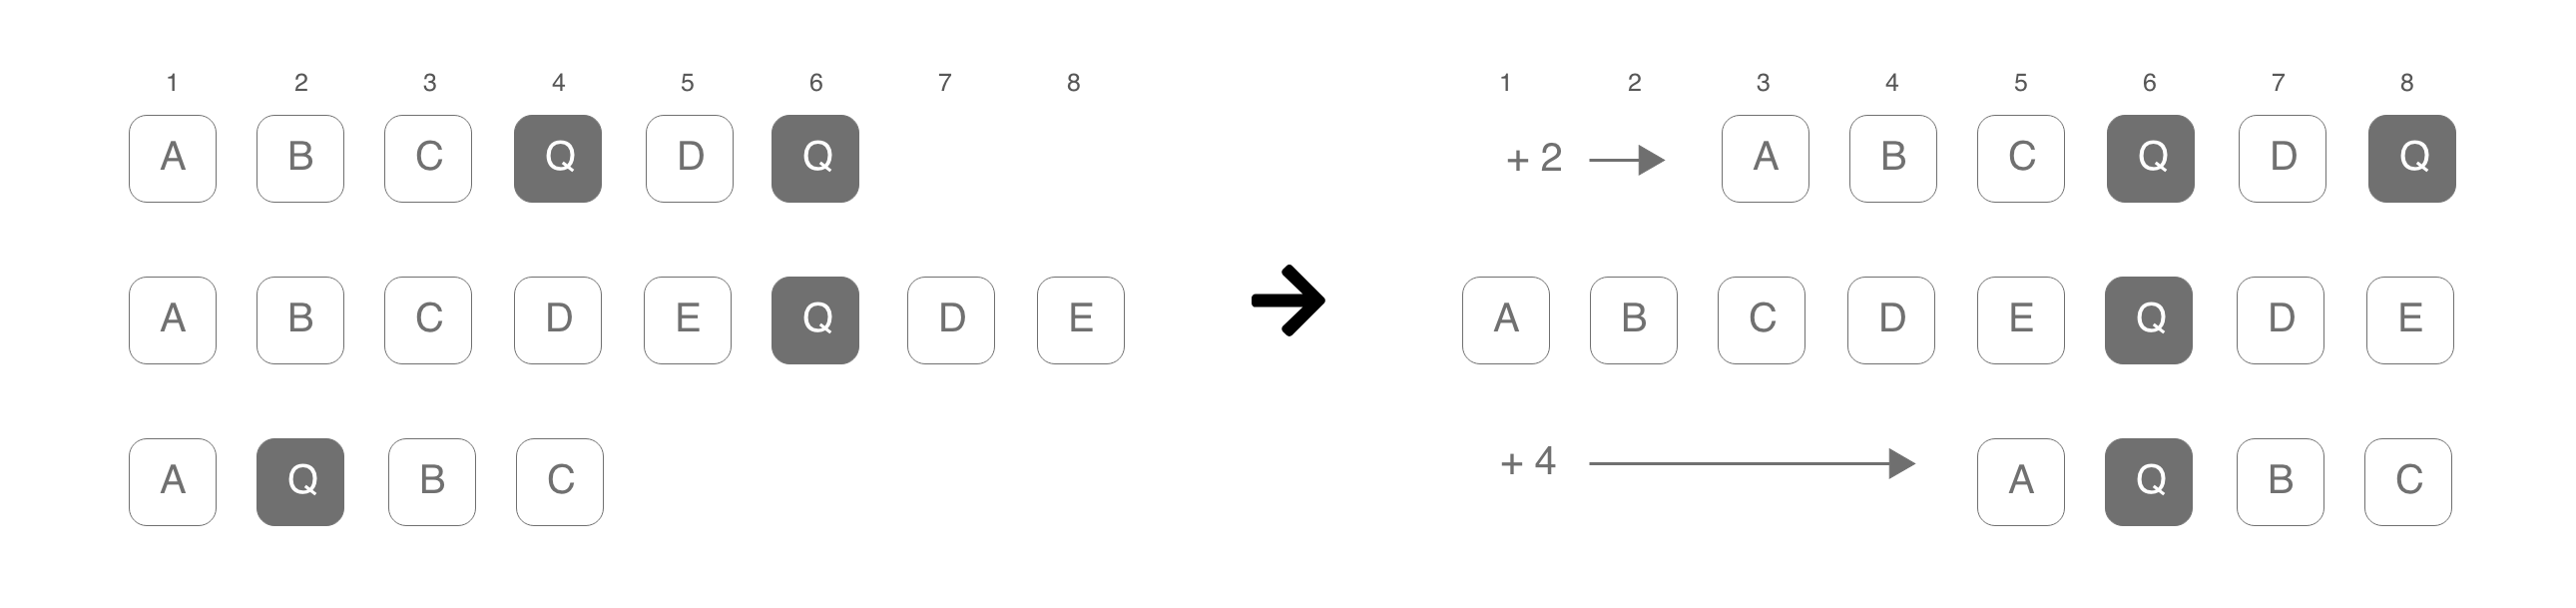

*Figure: the alignment process, "Q" as the queried trajectory point("Bakeries")*

In [8]:
queryMCC = "Bakeries"
#filter all the trajectory points whose MCCs equal query MCC(Bakeries)
test_data_query = test_time_range_filtered.loc[test_time_range_filtered["mcc"] == queryMCC]
#get largest min "max first position" of the queried MCC in the route as the "left alignment position"
grouped_test_data_query = test_data_query.groupby("name")
left_alignment_pos = grouped_test_data_query["step"].min().max()
need_alignment = grouped_test_data_query["step"].min().dropna() < left_alignment_pos
alignment_offset = left_alignment_pos - grouped_test_data_query["step"].min().dropna()
test_data_query_route = test_time_range_filtered[test_time_range_filtered["name"].isin(need_alignment.index)]
#move the order acoording to offset
test_data_query_route.set_index("name", inplace = True)
test_data_query_route["offset"] = alignment_offset
test_data_query_route["step"] = test_data_query_route["step"] + test_data_query_route["offset"]
test_data_query_route.head()

,mcc,time,transaction_value,time_interval_to_next,time_interval_from_last,step,offset
name,,,,,,,
people1,Fast Food Restaurants,2020-04-30 12:04:00,75,01:46:00,03:04:00,8,7
people1,"Furniture, Home Furnishings, and Equipment Sto...",2020-04-30 13:50:00,45,00:24:00,01:46:00,9,7
people1,Bakeries,2020-04-30 14:14:00,13,01:35:00,00:24:00,10,7
people1,Drug Stores and Pharmacies,2020-04-30 15:49:00,24,01:33:00,01:35:00,11,7
people1,Bakeries,2020-04-30 17:22:00,79,02:41:00,01:33:00,12,7


Then, the data is transformed to the form in which each row is a trajectory.

In [9]:
test_data_query_route.drop(columns = ["offset"])
shaped_routes = test_data_query_route.pivot(index = test_data_query_route.index, columns =  "step")
shaped_routes.head()

mcc                                \
step         1    2    3    4    5    6    7    
name                                            
people1     NaN  NaN  NaN  NaN  NaN  NaN  NaN   
people10    NaN  NaN  NaN  NaN  NaN  NaN  NaN   
people100   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
people1000  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
people1001  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                                                               \
step                                                       8    
name                                                            
people1                                 Fast Food Restaurants   
people10                                                  NaN   
people100   Furniture, Home Furnishings, and Equipment Sto...   
people1000                                                NaN   
people1001                                                NaN   

                                                                         ...  \
step                                                       9         10  ...   
name                                                                     ...   
people1     Furniture, Home Furnishings, and Equipment Sto...  Bakeries  ...   
people10                                Fast Food Restaurants  Bakeries  ...   
people100                               Fast Food Restaurants  Bakeries  ...   
people1000                                                NaN  Bakeries  ...   
people1001                                                NaN  Bakeries  ...   

           offset                                          
step           10   11   12   13   14  15  16  17  18  19  
name                                                       
people1       7.0  7.0  7.0  NaN  NaN NaN NaN NaN NaN NaN  
people10      8.0  8.0  8.0  8.0  8.0 NaN NaN NaN NaN NaN  
people100     7.0  7.0  7.0  NaN  NaN NaN NaN NaN NaN NaN  
people1000    9.0  9.0  9.0  NaN  NaN NaN NaN NaN NaN NaN  
people1001    9.0  9.0  9.0  NaN  NaN NaN NaN NaN NaN NaN  

[5 rows x 114 columns]

Next, **aggregation** is conducted, and the data for visualization is generated.

Basically, the following codes can return data about nodes(trajectory points - MCCs) and links(trajectories - connection of MCCs) in one step by doing these things(still take MCC as example):
1. Apply all the filters.
2. Find most visited MCCs that have connections with last step's MCC(s). *(nodes_result)*
3. Based on the MCCs' result, find all the links connecting two steps' MCCs. *(links_result)*

In [10]:
%%time
#time interval filter
time_interval_limit = pd.offsets.Minute(200)
#set the query center("Bakeries") as step 0(single_sequence), so the steps before are with minus numbers and steps after with positive nums.
#here, single_sequence = 1, which means the next station people go after they go to "Bakeries"
single_sequence = -1
#calculate step pos in the data
raw_step = single_sequence + left_alignment_pos
#the max number of nodes(MCCs) shown in a single step in the visulization
keep_rank_num = 6


if single_sequence > 0:
    source_step = raw_step-1
    target_step = raw_step
    #filter the data by time interval
    filtered_routes = shaped_routes[(shaped_routes["time_interval_to_next"][source_step] < time_interval_limit) & (shaped_routes["time_interval_from_last"][target_step] < time_interval_limit)]
    links = filtered_routes["mcc"][[source_step,target_step]].rename(columns = {source_step:"source", target_step:"target"})
elif single_sequence < 0:
    source_step = raw_step+1
    target_step = raw_step
    filtered_routes = shaped_routes[(shaped_routes["time_interval_to_next"][target_step] < time_interval_limit) & (shaped_routes["time_interval_from_last"][source_step] < time_interval_limit)]
    links = filtered_routes["mcc"][[source_step,target_step]].rename(columns = {source_step:"source", target_step:"target"})

#filter links into last step routes, then all the sources should be same as last steps' target
if abs(single_sequence) > 1:
    print("lll")
    links = links[links.index.isin(last_step_routes)]

# add transaction value column
links["transaction_value"] = filtered_routes.xs(("transaction_value", target_step), axis=1)
links["transaction_type"] = filtered_routes.xs(("transaction_type", target_step), axis=1)
links["merchant"] = filtered_routes.xs(("merchant", target_step), axis=1)
# column lists that use later
columns_transaction_type = ["source", "target", "transaction_type", "transaction_value"]
columns_transaction_value = ["target", "transaction_value"]
# get nodes grouped
nodes_g = links[columns_transaction_value].groupby(["target"]).count().rename(columns = {"transaction_value":"count"}).reset_index()
# capture nodes' route
nodes_g["route"] = links[columns_transaction_value].groupby(["target"]).groups.values()
# filter: node count >0
nodes_g = nodes_g[nodes_g["count"] > 0].reset_index(drop=True)
# group to deal with transaction type
nodes_transtype_groupby = links[columns_transaction_type].drop(columns = ["source"]).groupby(by = ["target", "transaction_type"])
nodes_transtype = nodes_transtype_groupby.count().dropna()
# get routes from diff transaction types
nodes_transtype["type_routes"] = list(nodes_transtype_groupby.groups.values())
nodes_transtype_cnt = nodes_transtype.unstack()["transaction_value"].reset_index().sort_values(by = ["target"]).reset_index(drop=True)
nodes_transtype_routes = nodes_transtype.unstack()["type_routes"].reset_index().sort_values(by = ["target"]).reset_index(drop=True)
# add trans type count
nodes_g["offline_count"] = nodes_transtype_cnt["offline"]
nodes_g["online_count"] = nodes_transtype_cnt["online"]
# add trans type trajectory id
nodes_g["offline_route"] = nodes_transtype_routes["offline"]
nodes_g["online_route"] = nodes_transtype_routes["online"]
#add atv
nodes_g["atv"] = links.groupby(["target"]).mean().dropna()["transaction_value"].reset_index(drop=True)
# get largest X results
nodes_result = nodes_g.nlargest(keep_rank_num, "count").reset_index(drop=True)
# convert array to list - for jsonify
nodes_result["route"] = nodes_result["route"].apply(lambda x: x.tolist())
for row in nodes_result.loc[nodes_result["offline_route"].isna(), "offline_route"].index:
    nodes_result.at[row, "offline_route"] = np.array([])
for row in nodes_result.loc[nodes_result["online_route"].isna(), "online_route"].index:
    nodes_result.at[row, "online_route"] = np.array([])
nodes_result["offline_count"].fillna(0, inplace = True)
nodes_result["online_count"].fillna(0, inplace = True)
nodes_result["offline_route"] = nodes_result["offline_route"].apply(lambda x: x.tolist())
nodes_result["online_route"] = nodes_result["online_route"].apply(lambda x: x.tolist())
# get routes of top nodes 
this_step_routes = []
for routes in nodes_result["route"]:
    this_step_routes += routes
# get all links in this step's route
links = links[links.index.isin(this_step_routes)]
# get links grouped into source + target + count format df
links_g = links.groupby(["source","target"]).count().rename(columns = {"merchant":"count"}).reset_index().dropna()
# print(links_g)
# capture links' routes by people's identifier/name
links_g["route"] = links.groupby(["source","target"]).groups.values()
# add atv column
links_g["atv"] = links[["source", "target", "transaction_value"]].groupby(["source","target"]).mean().dropna().reset_index()["transaction_value"]
links_transtype_groupby = links[columns_transaction_type].groupby(by = ["source", "target", "transaction_type"])
links_transtype = links_transtype_groupby.count().dropna()
# group to deal with transaction type
links_transtype["type_routes"] = list(links_transtype_groupby.groups.values())
links_transtype_cnt = links_transtype.unstack()["transaction_value"].reset_index().sort_values(by = ["source", "target"]).reset_index()
links_transtype_routes = links_transtype.unstack()["type_routes"].reset_index().sort_values(by = ["source", "target"]).reset_index()
# add trans type count
links_g["offline_count"] = links_transtype_cnt["offline"]
links_g["online_count"] = links_transtype_cnt["online"]
# add trans type traj id
links_g["offline_route"] = links_transtype_routes["offline"]
links_g["online_route"] = links_transtype_routes["online"]
# generate results
links_result = links_g.reset_index(drop = True).drop(columns = ["transaction_value"])
# print(links_result)
# print(links_result["offline_route"].isna())

# convert array to list
links_result["route"] = links_result["route"].apply(lambda x: x.tolist())
#fill null list
for row in links_result.loc[links_result["offline_route"].isna(), "offline_route"].index:
    links_result.at[row, "offline_route"] = np.array([])
for row in links_result.loc[links_result["online_route"].isna(), "online_route"].index:
    links_result.at[row, "online_route"] = np.array([])
links_result["offline_count"].fillna(0, inplace = True)
links_result["online_count"].fillna(0, inplace = True)
links_result["offline_route"] = links_result["offline_route"].apply(lambda x: x.tolist())
links_result["online_route"] = links_result["online_route"].apply(lambda x: x.tolist())

links_result_dict = links_result.to_dict('records')
nodes_result_dict = nodes_result.to_dict('records')

last_step_routes = this_step_routes

In [11]:
nodes_result

step,target,count,route
0,Drug Stores and Pharmacies,816,"[people1, people100, people1003, people1004, p..."
1,Bakeries,254,"[people1041, people1051, people1056, people112..."
2,"Grocery Stores, Supermarkets",238,"[people1006, people1014, people107, people1084..."
3,"Motor Freight Carriers, Moving and Storage Com...",191,"[people1026, people1035, people1042, people109..."
4,"Furniture, Home Furnishings, and Equipment Sto...",166,"[people1015, people1028, people1082, people117..."


In [12]:
links_result

step,source,target,count,route,atv
0,Bakeries,Bakeries,254.0,"[people1041, people1051, people1056, people112...",45.405512
1,Bakeries,Drug Stores and Pharmacies,816.0,"[people1, people100, people1003, people1004, p...",45.074755
2,Bakeries,"Furniture, Home Furnishings, and Equipment Sto...",166.0,"[people1015, people1028, people1082, people117...",46.090361
3,Bakeries,"Grocery Stores, Supermarkets",238.0,"[people1006, people1014, people107, people1084...",45.478992
4,Bakeries,"Motor Freight Carriers, Moving and Storage Com...",191.0,"[people1026, people1035, people1042, people109...",45.879581
